# Miguel Williams z1880434
# Jacob Keene z1651665
</br>

## Sentiment Analysis Example Using DistilBERT
</br>

### For our spotlight we are going to fine tune a BERT model to perform a polarity sentiment analsys (positive or negative review). We use the huggingface transformers library to import a pre-trained distilBERT model. We then use tensorflow/keras to fine-tune the model on the IMDB dataset.

In [ ]:
#install transformers
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 6.5 MB/s 
     |████████████████████████████████| 163 kB 64.7 MB/s 
     |████████████████████████████████| 7.6 MB 47.3 MB/s 


In [ ]:
#import google colab and connect to a driver to mount content
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#imports
import os
import numpy as np
import pandas as pd

### Below we use pandas to read the cvs or the IMDB dataset. We later use sklearn's train_test_split to separate the data into a training set, a validation set, and a testing set. This is standard procedure when training models.

In [ ]:
#Read the IMDB Dataset
data = pd.read_csv('/content/drive/MyDrive/IMDB Dataset.csv')

In [ ]:
#show what the IMDB Dataset looks like
print(data.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [ ]:
#import Sklearn to split data
from sklearn.model_selection import train_test_split

### Here we use the replace method to turn the positive and negative categories into 0 and 1 respectively so the model has an easier time handling the categorical data.

In [ ]:
from tensorflow.keras.utils import to_categorical

#replace the positive and negative sentiment with 0 and 1 respectively
data.sentiment.replace(['positive', 'negative'], [0,1], inplace=True)
print(data)

                                                  review  sentiment
0      One of the other reviewers has mentioned that ...          0
1      A wonderful little production. <br /><br />The...          0
2      I thought this was a wonderful way to spend ti...          0
3      Basically there's a family where a little boy ...          1
4      Petter Mattei's "Love in the Time of Money" is...          0
...                                                  ...        ...
49995  I thought this movie did a down right good job...          0
49996  Bad plot, bad dialogue, bad acting, idiotic di...          1
49997  I am a Catholic taught in parochial elementary...          1
49998  I'm going to have to disagree with the previou...          1
49999  No one expects the Star Trek movies to be high...          1

[50000 rows x 2 columns]


In [ ]:
#separate parameters and labels
review = data.review
sentiment = data.sentiment

print(sentiment.head())

0    0
1    0
2    0
3    1
4    0
Name: sentiment, dtype: int64


In [ ]:
#split into train, validation, test
review_train, review_test, sentiment_train, sentiment_test = train_test_split(review, sentiment, test_size=0.2, random_state=10)
review_train, review_validate, sentiment_train, sentiment_validate = train_test_split(review_train, sentiment_train, test_size=0.25, random_state=10)

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

### Below we import the BERT tokenizer and the DistilBERT model from transformers. The tokenizer will properly tokenize the words to feed into the model.

In [ ]:
#importing distil BERT model and its tokenizer for Tesnforflow use
from transformers import DistilBertTokenizer, TFDistilBertModel

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'activation_13', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
#tokenize all of the training parameters
x_train = tokenizer(
    text=review_train.tolist(),
    add_special_tokens=True,
    max_length=512,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True)

In [ ]:
#import the tensorflow and keras packages to fine tune the BERT model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy


import tensorflow as tf

In [ ]:
from tensorflow.keras import layers

### Here we set up the model using tensorflow/keras. The model consists of two inputs, the input_ids and attention masks obtained from the BERT tokenizer. It is then fed into the distil BERT model for proper embeddings. The embeddings then go through various Dense layers.

In [ ]:
#set up the Neural Network for fine tuning and creat the model
max_length = 512 #The max length of input

input_ids = layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
input_mask = layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')

embeddings = model(input_ids, attention_mask=input_mask)[0]
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = layers.Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = layers.Dense(32, activation='relu')(out)

y=layers.Dense(6, activation='sigmoid')(out)

final_model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
final_model.layers[2].trainable=True

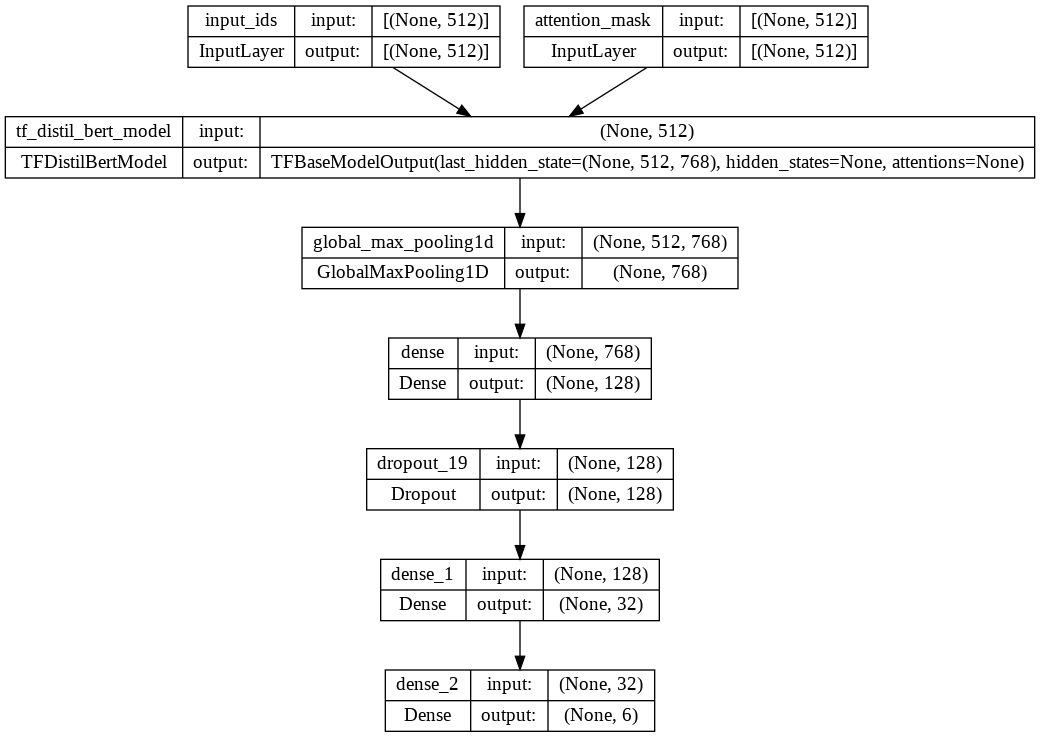

In [ ]:
tf.keras.utils.plot_model(final_model, show_shapes=True)

### The choice of opimizer is Adam which is a state of the art optimizer. The loss is we are using is Sparse Categorical Crossentropy.

In [ ]:
optimizer = Adam(learning_rate=5e-05,
                 epsilon=1e-08,
                 decay=0.01,
                 clipnorm=1.0)

//loss = CategoricalCrossentropy(from_logits=True)
metric = CategoricalAccuracy('balanced_accuracy')

final_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=metric
)

In [ ]:
#tokenize the validation set
x_validate = tokenizer(
    text=review_validate.tolist(),
    add_special_tokens=True,
    max_length=512,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True)

#tokenize the test set
x_test = tokenizer(
    text=review_test.tolist(),
    add_special_tokens=True,
    max_length=512,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True)

In [ ]:
#obtain the saved model checkpoint to prevent re-training
checkpoint_path = "training_1.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

#save the model weights
callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                              save_weights_only = True,
                                              verbose=1)

In [ ]:
#load the weights into the model
final_model.load_weights("/content/drive/MyDrive/training_1.ckpt")

In [ ]:
#fit the model with the train set
#Only needed to be ran once for demo and testing saving and loading model weights

#train_history = final_model.fit(
#    x = {'input_ids':x_train['input_ids'], 'attention_mask':x_train['attention_mask']},
#    y = sentiment_train,
#    validation_data = (
#        {'input_ids':x_validate['input_ids'], 'attention_mask':x_validate['attention_mask']},
#        sentiment_validate
#    ),
#    epochs=1,
#    batch_size=5,
#    callbacks=[callback]
#)

6000/6000 [==============================] - ETA: 0s - loss: 0.2764 - balanced_accuracy: 0.5012
Epoch 1: saving model to training_1.ckpt
6000/6000 [==============================] - 2109s 350ms/step - loss: 0.2764 - balanced_accuracy: 0.5012 - val_loss: 0.2302 - val_balanced_accuracy: 0.4915


### After the model is fine-tuned we use the test data to see if the model generalized well.

In [ ]:
#get predictions on the testing set to see if the model generalized
predictions = final_model.predict(x={'input_ids':x_test['input_ids'], 'attention_mask':x_test['attention_mask']})

313/313 [==============================] - 193s 607ms/step


In [ ]:
print(predictions)

[[9.9632627e-01 9.9787831e-01 5.8875799e-01 1.5401302e-04 3.2756737e-01
  4.3158153e-01]
 [9.7586489e-01 9.9956137e-01 6.5568179e-01 8.5503492e-04 3.7011144e-01
  6.1854374e-01]
 [9.9660766e-01 9.9633253e-01 5.9417248e-01 1.7112338e-04 3.2953283e-01
  3.6776108e-01]
 ...
 [9.7951102e-01 9.9983037e-01 6.7230403e-01 5.3593732e-04 3.9709020e-01
  7.0192951e-01]
 [9.7435445e-01 9.9986434e-01 6.6301942e-01 4.0876045e-04 3.6661530e-01
  6.9112265e-01]
 [9.9864954e-01 9.4686401e-01 2.4524359e-01 3.4562958e-04 1.6912681e-01
  1.9118996e-01]]


### As we can see here from a small sample of 5 test sets, the model correctly predicted 4 of the 5.

In [ ]:
#get classification_report to obtain precision, recall, and f1-score
from sklearn.metrics import classification_report
y_predictions = np.argmax(predictions, axis=1) #extract the actual value

#check to see if the predicition is matching some/any of the actual output
print(y_predictions[100:105])
print(sentiment_test[100:105])

[1 0 0 1 1]
3059     1
49051    0
109      0
20851    1
39952    0
Name: sentiment, dtype: int64


### We use sklearns classification_report to get the precision, recall, and f1-score of the test data vs what was actually there. The model looks to have 91% accuracy.

In [ ]:
#show the classification report
print(classification_report(sentiment_test, y_predictions))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      4892
           1       0.91      0.92      0.91      5108

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

